# Bebossing detector
Dit notebook gaat in op het kunnen detecteren van bebossing vanuit satellietfoto's d.m.v. een semantic segmentation oplossing (U-Net).

# Contact
Gerrit van de Bunt (gerrit.vandebunt@student.hu.nl)\
Wail Abou (wail.abou@student.hu.nl)\
Wijnand van Dijk (wijnand.vandijk@student.hu.nl)

http://localhost:8888/notebooks/src/notebooks/unet.ipynb#Contact

# Initialisatie
Importeer alle nodige functies/classes voor onze notebook.

In [3]:
import os
import random
import tensorflow as tf
from typing import Union
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
from matplotlib import pyplot as plt
import random as rnd
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
import packaging
import tensorflow
keras.__version__

In [4]:
# if not os.path.exists('../data'):
#     from python_scripts.onedrive_helper import *
#     oh = OneDriveHelper()
#     oh.download('data', '../')

De cel beneden zorgt ervoor dat GPU's gebruikt worden als deze aanwezig zijn en als dat mogelijk is (CUDA benodigd)

In [5]:
gpu_amount = len(tf.config.experimental.list_physical_devices('GPU'))
print(f'GPU acceleration enabled = {gpu_amount > 0}')

GPU acceleration enabled = False


# Data
Eerst doen we een analyse op de data. Onze data is als volgt georganiseerd;
- Er zijn telkens paren van true-color-images en masks
- De masks zijn greyscaled met een waarde van 0 of 1 per pixel; 0 stelt 'geen bebossing' voor en 1 'wel bebossing'.

Standaard gebruiken we hier onze gegenereerde masks van West Bengal. Voor elke locatie in West Bengal zijn foto's en masks genomen van 3 jaren.

In [6]:
# Attributen van afbeeldingen
input_dir = "../data/Model Input Data/West_Bengal_15_geolocations_v2/true_colours_images_testset_v2"
target_dir = "../data/Model Input Data/West_Bengal_15_geolocations_v2/mask_completed"
img_size = (512, 512)  # 512x512
num_classes = 2  # 2 soorten labels, zoals eerder besproken
batch_size = 1  # Hoeveel afbeeldingen er in één batch moeten.

input_img_paths = sorted([
    os.path.join(input_dir, fname) 
    for fname in os.listdir(input_dir) 
    if fname.endswith(".png")])

target_img_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")])

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 56
../data/Model Input Data/West_Bengal_15_geolocations_v2/true_colours_images_testset_v2\86.99694333333332_21.886076666666664_87.04394333333333_21.93307666666666_2017-01-01_2018-01-01.png | ../data/Model Input Data/West_Bengal_15_geolocations_v2/mask_completed\86.99694333333332_21.886076666666664_87.04394333333333_21.93307666666666_2017-01-01_2018-01-01.png
../data/Model Input Data/West_Bengal_15_geolocations_v2/true_colours_images_testset_v2\86.99694333333332_21.886076666666664_87.04394333333333_21.93307666666666_2018-01-01_2019-01-01.png | ../data/Model Input Data/West_Bengal_15_geolocations_v2/mask_completed\86.99694333333332_21.886076666666664_87.04394333333333_21.93307666666666_2018-01-01_2019-01-01.png
../data/Model Input Data/West_Bengal_15_geolocations_v2/true_colours_images_testset_v2\86.99694333333332_21.886076666666664_87.04394333333333_21.93307666666666_2019-01-01_2020-01-01.png | ../data/Model Input Data/West_Bengal_15_geolocations_v2/mask_completed\86.

Testsample volgt beneden

In [1]:
i = rnd.randrange(0, len(input_img_paths) - 1)

# Displays random input image
display(Image(filename=input_img_paths[i]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[i]))
display(img)

NameError: name 'rnd' is not defined

Om ons te helpen om de data in te laden creeëren we een Class waarmee we onze data kunnen organiseren. Deze class regelt alleen niet de train/val split, dat doen we later.

In [2]:
class SatelliteImages(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size)
            data = np.array(img)[:, :, 0]
            data = np.expand_dims(data, 2)
            y[j] = data
            y[j] = np.divide(y[j], 255)
        return x, y

NameError: name 'keras' is not defined

# Model
Voor het model hebben we besloten om gebruik te maken van het U-Net architectuur. Na onderzoek online naar image segmentation werd beargumenteerd dat U-Net modellen beter kunnen trainen op een kleinere testset dan bijvoorbeld een variant van R-CNN. Daar tegenover stond dan weer wel dat U-Net er langer over doet om te trainen omdat het computationeel zwaar is om te trainen.

Bronnen:

-

TODO!

In [17]:
def get_model(img_size, num_classes: int):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [21]:
# Split our img paths into a training and a validation set using 80/20 split
val_samples = int(len(input_img_paths) * 0.2)
seed = 1337
random.Random(seed).shuffle(input_img_paths)
random.Random(seed).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = SatelliteImages(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = SatelliteImages(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [28]:
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, y_true=None, y_pred=None, num_classes=None, name='mean_iou', dtype=None):
        super(MeanIoU, self).__init__(num_classes = num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [30]:
class Precision(tf.keras.metrics.Precision):
    def __init__(self, y_true=None, y_pred=None, name='precision', dtype=None):
        super(Precision, self).__init__(name=name, dtype=dtype)
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [31]:
class Recall(tf.keras.metrics.Recall):
    def __init__(self, y_true=None, y_pred=None, name='recall', dtype=None):
        super(Recall, self).__init__(name=name, dtype=dtype)
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [32]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.

model = get_model(img_size, num_classes)

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=[MeanIoU(num_classes=2), Precision(), Recall()])
# model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=[MeanIoU(num_classes=2)])
callbacks = [keras.callbacks.ModelCheckpoint("image_segmentation.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
epochs = 8
reshistory = model.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=val_gen)

Epoch 1/8
45/45 [==============================] - 58s 1s/step - loss: 1.8639 - mean_iou: 0.5484 - precision: 0.5192 - recall: 0.5924 - val_loss: 0.7018 - val_mean_iou: 0.5244 - val_precision: 0.9752 - val_recall: 0.2539
Epoch 2/8
45/45 [==============================] - 59s 1s/step - loss: 0.4598 - mean_iou: 0.6441 - precision: 0.6947 - recall: 0.6393 - val_loss: 0.3796 - val_mean_iou: 0.6599 - val_precision: 0.6178 - val_recall: 0.8104
Epoch 3/8
45/45 [==============================] - 60s 1s/step - loss: 0.4007 - mean_iou: 0.6504 - precision: 0.7044 - recall: 0.6339 - val_loss: 0.5712 - val_mean_iou: 0.6595 - val_precision: 0.6205 - val_recall: 0.8012
Epoch 4/8
45/45 [==============================] - 61s 1s/step - loss: 0.3327 - mean_iou: 0.7077 - precision: 0.7611 - recall: 0.7030 - val_loss: 0.5631 - val_mean_iou: 0.4541 - val_precision: 0.6835 - val_recall: 0.1604
Epoch 5/8
45/45 [==============================] - 62s 1s/step - loss: 0.3031 - mean_iou: 0.7093 - precision: 0.7671

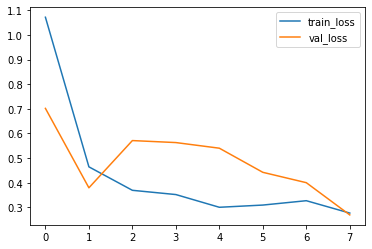

In [33]:
plt.plot(reshistory.history['loss'],label="train_loss")
plt.plot(reshistory.history['val_loss'],label="val_loss")
plt.legend()
plt.show()

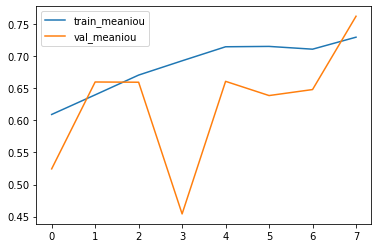

In [34]:
plt.plot(reshistory.history['mean_iou'],label="train_meaniou")
plt.plot(reshistory.history['val_mean_iou'],label="val_meaniou")
plt.legend()
plt.show()

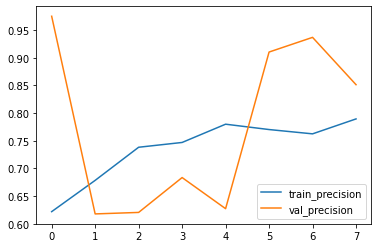

In [35]:
plt.plot(reshistory.history['precision'],label="train_precision")
plt.plot(reshistory.history['val_precision'],label="val_precision")
plt.legend()
plt.show()

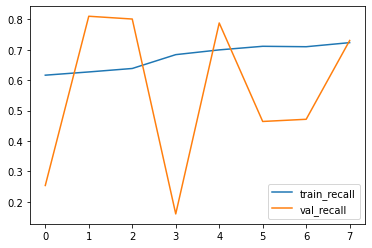

In [36]:
plt.plot(reshistory.history['recall'],label="train_recall")
plt.plot(reshistory.history['val_recall'],label="val_recall")
plt.legend()
plt.show()

In [37]:
reshistory.history['loss']

[1.0715521574020386,
 0.46463918685913086,
 0.3694266080856323,
 0.3521712124347687,
 0.3005746603012085,
 0.30955222249031067,
 0.3272545635700226,
 0.27706047892570496]

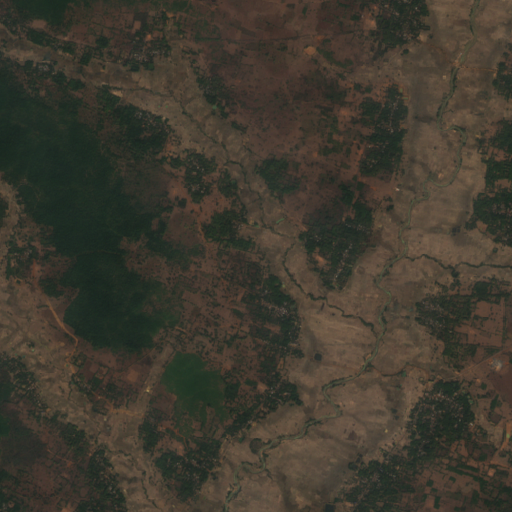

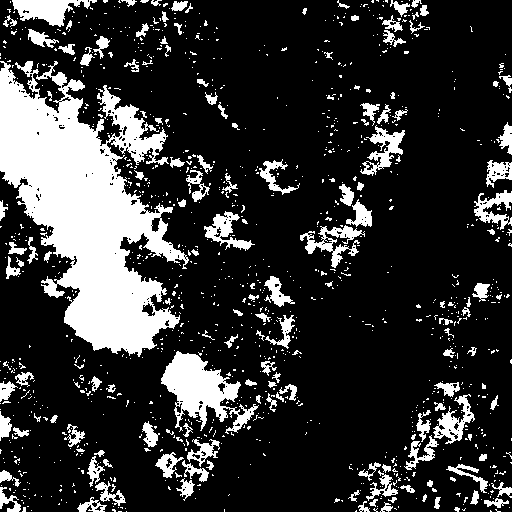

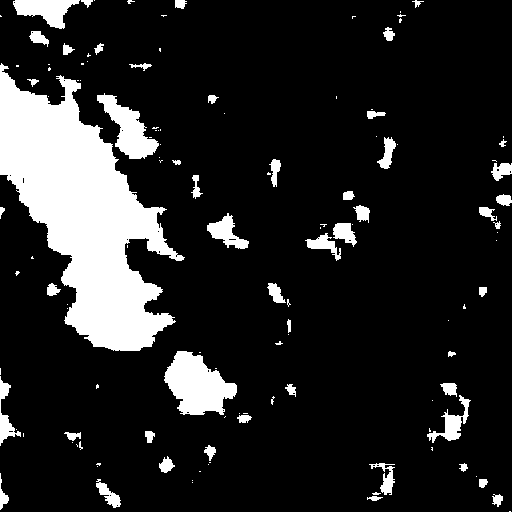

In [38]:
# Generate predictions for all images in the validation set

val_gen = SatelliteImages(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #0
i = rnd.randrange(0, len(val_input_img_paths) - 1)

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

In [50]:
testsample = val_preds[i]
testsample

array([[[0.56922275, 0.43077728],
        [0.7347913 , 0.26520875],
        [0.7423376 , 0.25766236],
        ...,
        [0.95244575, 0.04755425],
        [0.9531345 , 0.04686555],
        [0.8343678 , 0.16563219]],

       [[0.5921039 , 0.40789613],
        [0.6997197 , 0.30028027],
        [0.7151453 , 0.2848547 ],
        ...,
        [0.8819736 , 0.11802643],
        [0.8765666 , 0.12343343],
        [0.72794497, 0.27205506]],

       [[0.6125963 , 0.3874037 ],
        [0.71673524, 0.28326476],
        [0.74004906, 0.25995094],
        ...,
        [0.8798361 , 0.12016391],
        [0.89028007, 0.10971994],
        [0.7762559 , 0.22374406]],

       ...,

       [[0.4910307 , 0.5089693 ],
        [0.5953835 , 0.40461648],
        [0.622066  , 0.37793398],
        ...,
        [0.6508911 , 0.3491089 ],
        [0.6703143 , 0.32968572],
        [0.62080264, 0.37919733]],

       [[0.5113047 , 0.48869526],
        [0.5607027 , 0.43929735],
        [0.5686288 , 0.4313712 ],
        .

In [3]:
def read_model_output(data, conftreshold=None, confbasevalue=0):
    as_matrix = data.copy()
    if conftreshold is not None:
        # Get indices of highest element in probability list (base predictions)
        maxindices = np.argmax(data,axis=-1)
        # Create matrice for final predictions
        results = np.zeros(maxindices.shape)
        # Iterate over matrice
        # Assign iterator to a object so we can get it's multi_index.
        iterator = np.nditer(maxindices, flags=['multi_index']) 
        for x in iterator:
            if data[(iterator.multi_index[0], iterator.multi_index[1], x)] >= conftreshold:
                results[(iterator.multi_index[0], iterator.multi_index[1])] = maxindices[(iterator.multi_index[0], iterator.multi_index[1])]
            else:
                results[iterator.multi_index] = confbasevalue
        return results
    else:
        results = np.argmax(data,axis=-1)
    return results

In [4]:
out = read_model_output(testsample, 0.8)
display(np.unique(out))
display((out == 0).sum())
display((out == 1).sum())
out

NameError: name 'testsample' is not defined

In [105]:
testsample2 = np.argmax(val_preds[i], axis=-1)
display((testsample2 == 0).sum())
display((testsample2 == 1).sum())
testsample2

224046

38098

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0]], dtype=int64)

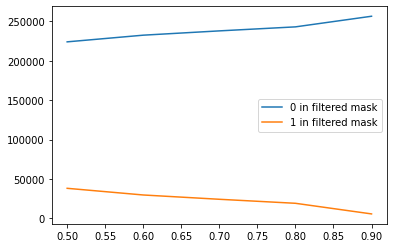

In [111]:
zeros, ones = [], []
tresholds = [0.5,0.6,0.7,0.8,0.9]
for x in tresholds:
    data = read_model_output(testsample, x)
    zeros.append((data == 0).sum())
    ones.append((data == 1).sum())
plt.plot(tresholds,zeros,label="0 in filtered mask")
plt.plot(tresholds,ones,label="1 in filtered mask")
plt.legend()
plt.show()

In [42]:
# Hyperparameter optimalisation;
# Here we define a couple of variations of the model above with slight adjustments to the hyperparameters/structure
# The performance of these models is analysed to determine the best model architecture for our current problem.

In [43]:
def alt_model_1(img_size, num_classes):
    """Alternative model getter that emphasises on additional filters."""
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(64, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [512, 256, 128, 64]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


def alt_model_2(img_size, num_classes):
    """Alternate model getter that emphasises on a additional up/downsampling layer"""
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [512, 256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [44]:
# Model trialing.

models = [{"name":"baseline","model":get_model,"opt":"rmsprop"},
          {"name":"filters","model":alt_model_1,"opt":"rmsprop"},
          {"name":"up-downsampling","model":alt_model_2,"opt":"rmsprop"}]

In [45]:
def get_axes_row_col(index, cols):
    row = index // cols
    col = index % cols
    return row, col

In [46]:
history = []
for entry in models:
    ho_model = entry["model"](img_size, num_classes)
    ho_model.compile(optimizer=entry["opt"], loss="sparse_categorical_crossentropy", metrics=[MeanIoU(num_classes=2),Precision(),Recall()])
    callbacks = [keras.callbacks.ModelCheckpoint("image_segmentation_{}.h5".format(entry["name"]), save_best_only = True)]
    outcome = ho_model.fit(train_gen, epochs=15, callbacks=callbacks, validation_data=val_gen)
    history.append(outcome.history)

Epoch 1/15
45/45 [==============================] - 68s 1s/step - loss: 2.4480 - mean_iou: 0.5564 - precision: 0.5543 - recall: 0.6201 - val_loss: 1.1610 - val_mean_iou: 0.3740 - val_precision: 0.2171 - val_recall: 0.0039
Epoch 2/15
45/45 [==============================] - 63s 1s/step - loss: 0.4161 - mean_iou: 0.6393 - precision: 0.6684 - recall: 0.6263 - val_loss: 0.5004 - val_mean_iou: 0.3812 - val_precision: 0.4084 - val_recall: 0.0196
Epoch 3/15
45/45 [==============================] - 71s 2s/step - loss: 0.3812 - mean_iou: 0.6763 - precision: 0.7068 - recall: 0.7026 - val_loss: 0.5170 - val_mean_iou: 0.3747 - val_precision: 0.3773 - val_recall: 0.0032
Epoch 4/15
42/45 [===========================>..] - ETA: 4s - loss: 0.3051 - mean_iou: 0.6937 - precision: 0.7946 - recall: 0.6458

KeyboardInterrupt: 

In [ ]:
def plot_model_history(metric, history, models):
    ncols = len(models)
    fig, ax = plt.subplots(nrows=1, ncols=ncols, squeeze=False)
    fig.set_size_inches(18.5, 10.5)
    
    for grid_indexor in range(len(models)):
        row, col = get_axes_row_col(grid_indexor, ncols)
        # Plot desired metric
        ax[row, col].plot(history[grid_indexor][metric], label=f"{entry['name']} train_loss")
        ax[row, col].plot(history[grid_indexor][f"val_{metric}"], label=f"{entry['name']} val_loss")
    
    plt.legend()
    plt.suptitle(f'History of {metric}', fontsize=20)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_model_history('mean_iou', history, models)

In [ ]:
plot_model_history('loss', history, models)

In [ ]:
plot_model_history('precision', history, models)

In [ ]:
plot_model_history('recall', history, models)